

МЕТОД СТРЕЛЬБЫ

Число итераций: 1
Число итераций: 1
Абсолютная ошибка для сетки 0.01: 0.031104233836003692
Абсолютная ошибка с уточнением по Рунге-Ромбергу: 0.01190106556452708




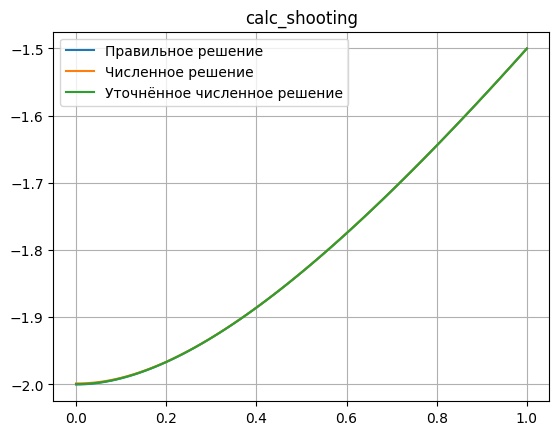



МЕТОД КОНЕЧНЫХ РАЗНОСТЕЙ

Абсолютная ошибка для сетки 0.01: 0.0034767545257301524
Абсолютная ошибка с уточнением по Рунге-Ромбергу: 2.0573802757883897e-05




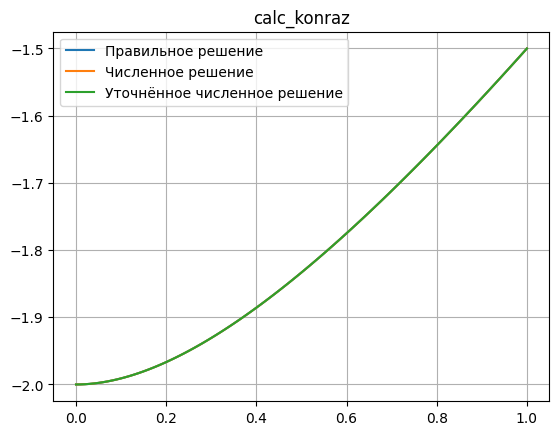

In [3]:
import os
import math
from matplotlib import pyplot as plt
from LU import LU_SOLVER

class NUMERIC_KOSHI_23:
    def __init__(self):
        """Параметры: x0, x1, первое условие в x0, второе условие в x0."""
        self.x0 = 0
        self.x1 = 1
        self.corner1 = 0
        self.precision = 1e-3
    
    def calc_eq(self, x, y, z):
        return (y-(x-3)*z)/(x**2-1)
    
    def calc_algor(self, z, y):
        val = z + y + 0.75
        return val

    def calc_solution(self, x):
        return x - 3 + 1/(x+1)
    
    def plot(self, x_array, integrated, refined, name):
        plt.plot(x_array, [solver.calc_solution(elem) for elem in x_array], label = 'Правильное решение')
        plt.plot(x_array, integrated, label = 'Численное решение')
        plt.plot(x_array, refined, label = 'Уточнённое численное решение')
        plt.title(name)
        plt.legend()
        plt.grid()
        plt.show()
    
    def calc_error(self, x_array, results):
        sum = 0
        
        for i in range (len(results)):
            sum += abs(results[i] - self.calc_solution(x_array[i]))

        return sum
    
    def runge(self, sum1, sum2):
        """Уточнить значение по Рунге-Ромбергу."""
        refined = [sum1[i] + (sum1[i] - sum2[i*2])/((1/2)**2 - 1) for i in range(len(sum1))]
        return refined
    
    def calc_eiler(self, h, corner0):
        """Рассчитать значения по Эйлеру."""
        
        x_prev = self.x0
        y_prev = corner0
        z_prev = self.corner1

        y_array = [y_prev]
        z_array = [z_prev]

        while (x_prev < self.x1 - h/10):
            y_new = y_prev + h * z_prev
            z_new = z_prev + h * self.calc_eq(x_prev, y_prev, z_prev)

            y_array.append(y_new)
            z_array.append(z_new)

            z_prev = z_new
            y_prev = y_new
            
            x_prev += h

        return y_array, z_array
    
    def calc_shooting(self, h) -> list:
        """Рассчитать значения методом стрельбы."""
        method = self.calc_eiler

        arg0 = 0.3
        arg1 = 0.5
        
        res0 = method(h, arg0)
        res1 = method(h, arg1)

        algor0 = self.calc_algor(res0[1][-1], res0[0][-1])
        algor1 = self.calc_algor(res1[1][-1], res1[0][-1])
        
        iters = 0

        while abs(algor1) > self.precision:
            iters += 1
            new_arg = arg1 - (arg1-arg0)/(algor1-algor0)*algor1
            new_res = method(h, new_arg)
            new_algor = self.calc_algor(new_res[1][-1], new_res[0][-1])

            arg0 = arg1
            arg1 = new_arg
            
            algor0 = algor1
            algor1 = new_algor

        print(f"Число итераций: {iters}")

        return new_res[0]

    def calc_konraz(self, h):
        """Рассчитать методом конечных разностей."""

        N = int( (self.x1-self.x0)/h )

        A = [[0 for _ in range(N+2)] for _ in range(N+1)]

        A[0][0] = -3
        A[0][1] = 4
        A[0][2] = -1

        for i in range(1, N):
            xi = self.x0 + h*i
            A[i][i-1] = (xi**2 - 1) - (xi - 3)*h/2
            A[i][i] = -2*(xi**2 - 1) - h**2
            A[i][i+1] = (xi**2 - 1) + (xi - 3)*h/2

        A[N][N-2] = 1
        A[N][N-1] = -4
        A[N][N] = 3 + 2*h
        A[N][N+1] = -1.5*h

        solver = LU_SOLVER()
        
        name = "temp"
        PATH = os.path.abspath('') + f"/{name}"

        with open(PATH, "w") as f:
            for line in A:
                for elem in line:
                    f.write(f"{elem} ")
                f.write("\n")
        
        solver.read_from_file(name)

        os.remove(PATH)

        return solver.solve()
    
    def wrapper(self, h, method):
        """Обернуть метод для выполнения общего набора действий."""
        sum1 = method(h)
        sum2 = method(h/2)
        refined = self.runge(sum1, sum2)
        x_array = [self.x0 + h*i for i in range(int((self.x1-self.x0)/h)+1)]
        
        print(f"Абсолютная ошибка для сетки {h}: {self.calc_error(x_array, sum1)}")
        print(f"Абсолютная ошибка с уточнением по Рунге-Ромбергу: {self.calc_error(x_array, refined)}\n\n")

        self.plot(x_array, sum1, refined, method.__name__)

    def wrapper_wrapper(self, h):
        """Вызвать все методы."""
        print("\n\nМЕТОД СТРЕЛЬБЫ\n")
        self.wrapper(h, self.calc_shooting)
        print("\n\nМЕТОД КОНЕЧНЫХ РАЗНОСТЕЙ\n")
        self.wrapper(h, self.calc_konraz)

if __name__ == "__main__":
    solver = NUMERIC_KOSHI_23()

    solver.wrapper_wrapper(0.01)